# Imports

In [5]:
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib
import matplotlib.pyplot as plt
import cftime
import dask
from dask_jobqueue import PBSCluster
from dask.distributed import Client
import glob
from geocat.viz import util as gvutil
import cartopy.crs as ccrs
import cartopy.feature as cf
import cartopy.util as cutil
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter

# Useful Functions

In [6]:
def detrend_dim(da, dim, deg=1):
    # detrend along a single dimension
    p = da.polyfit(dim=dim, deg=deg)
    fit = xr.polyval(da[dim], p.polyfit_coefficients)
    return da - fit


def index_plot(ds1, name1='', threshold=0.5):
    lim = 4 * threshold
    fig, ax = plt.subplots(figsize=(12, 6))
    
    ax.plot(ds1.time, ds1, color='black', label=name1)
    gvutil.add_major_minor_ticks(ax, x_minor_per_major=15, y_minor_per_major=3, labelsize=20)
    
    gvutil.set_axes_limits_and_ticks(ax, ylim=(-1*lim, lim))
    ax.fill_between(ds1.time, ds1, y2=-threshold,
                    where=ds1 < -threshold, color='blue', interpolate=True)
    ax.fill_between(ds1.time, ds1, y2=threshold,
                    where=ds1> threshold, color='red', interpolate=True)
    plt.title(f'{name1}')
    ax.set_xlabel('year', fontsize=24)
    plt.grid()
    plt.show()

# PBSClustter

In [7]:
# Create a PBS cluster object
cluster = PBSCluster(account='P93300313',
                     job_name='ATLN-ENSO-CESMLE2',
                     cores=1,
                     memory='8GiB',
                     processes=1,
                     walltime='02:00:00',
                     queue='casper',
                     interface='ext',
                     n_workers=1)

# dont scale many workers unless using LE
# cluster.scale(10)

client = Client(cluster)
client

Connection method: Cluster object,Cluster type: dask_jobqueue.PBSCluster
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/acruz/proxy/8787/status,
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/acruz/proxy/8787/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://128.117.208.186:44679,Workers: 0
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/acruz/proxy/8787/status,Total threads: 0
Started: Just now,Total memory: 0 B


In [8]:
cluster.scale(2)

In [9]:
# client.shutdown()
cluster.workers

{'PBSCluster-0': <dask_jobqueue.pbs.PBSJob: status=running>}

# Import

In [10]:
# start with hadisst files
ds = xr.open_dataset('/glade/campaign/collections/rda/data/d277003/HadISST_sst.nc.gz').compute()
ds

<xarray.Dataset> Size: 482MB
Dimensions:    (time: 1861, nv: 2, latitude: 180, longitude: 360)
Coordinates:
  * time       (time) datetime64[ns] 15kB 1870-01-16T11:59:59.505615234 ... 2...
  * latitude   (latitude) float32 720B 89.5 88.5 87.5 86.5 ... -87.5 -88.5 -89.5
  * longitude  (longitude) float32 1kB -179.5 -178.5 -177.5 ... 178.5 179.5
Dimensions without coordinates: nv
Data variables:
    time_bnds  (time, nv) float32 15kB 0.0 31.0 31.0 ... 5.661e+04 5.664e+04
    sst        (time, latitude, longitude) float32 482MB -1e+03 -1e+03 ... nan
Attributes:
    Title:                      Monthly version of HadISST sea surface temper...
    description:                HadISST 1.1 monthly average sea surface tempe...
    institution:                Met Office Hadley Centre
    source:                     HadISST
    reference:                  Rayner, N. A., Parker, D. E., Horton, E. B., ...
    Conventions:                CF-1.0
    history:                    3/3/2025 converted to netcdf from pp format
    supplementary_information:  Updates and supplementary information will be...
    comment:                    Data restrictions: for academic research use ...

# select

In [11]:
dates = xr.date_range(start='1920-01-16', end='2025-01-16', freq='1ME')
ds = ds.sel(time=dates, method='nearest')
ENSO34_hadisst = ds['sst'].sel(latitude=slice(5, -5), longitude=slice(-170, -120)).compute()

# ONI Index

In [12]:
# get weighted latitudes
weights = np.cos(np.deg2rad(ENSO34_hadisst.latitude))
weights.name = "weights"

In [13]:
ENSO34_clim = ENSO34_hadisst.groupby(ENSO34_hadisst['time'].dt.month).mean(dim='time').compute()
ENSO34_anom = ENSO34_hadisst.groupby(ENSO34_hadisst['time'].dt.month) - ENSO34_clim
# all anomaly fields were linearly detrended zhang et al
ENSO34_anom_dtrend = detrend_dim(ENSO34_anom, dim='time')

In [14]:
ENSO34_roll = ENSO34_anom_dtrend.rolling(time=3, center=True).mean()
ENSO34_index = ENSO34_roll.mean(('longitude', 'latitude'), skipna=True).compute()

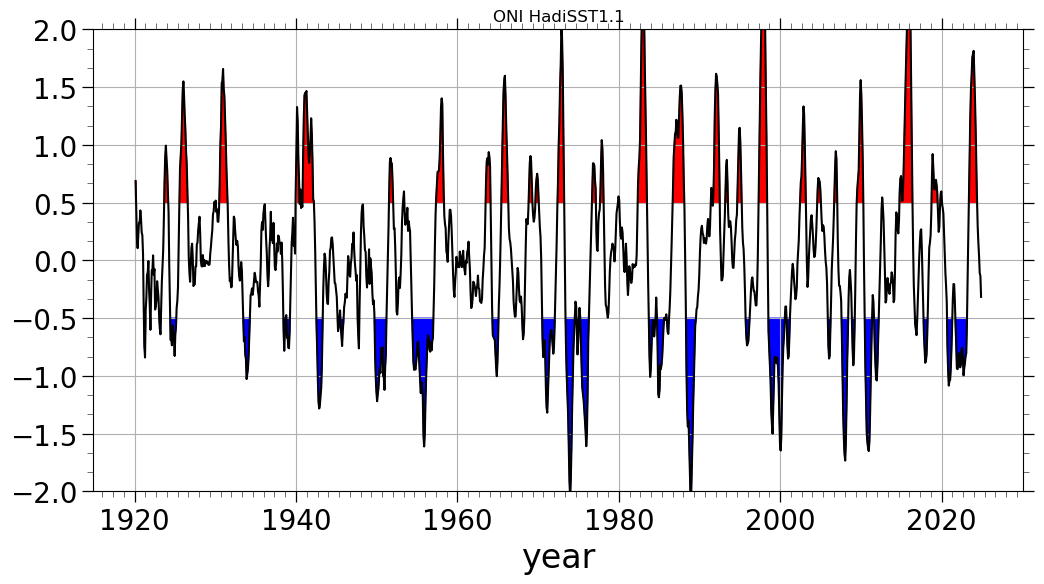

In [16]:
index_plot(ENSO34_index, name1='ONI HadiSST1.1')